### Дипломная работа Александра Соколова

#### Градиентный бустинг
Кернел 2 из 3 в разделе ML (отредактирован 21.04.2021)
---

# 1. Импорт библиотек, инициализация глобальных констант
## 1.1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import tqdm
import pickle

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance

import lightgbm as lgb
import catboost as cb

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import shap

np.warnings.filterwarnings('ignore')

## 1.2. Глобальные константы

In [2]:
# CURRENT_DIR = './'  # имя текущей директории для локальной машины 
CURRENT_DIR = '../'  # имя текущей директории для каггл

PATH_TO_WORKDIR = CURRENT_DIR + 'working/'

In [3]:
!pip freeze > requirements.txt

# 2. Импорт предобработанных данных
---
предобработка осуществлялась в [первом кернеле](https://www.kaggle.com/sokolovaleks/sf-dst-10-diplom-1-ml-sokolov)

In [4]:
merged_train_data = pd.read_csv('../input/alfabattle2-sandbox/preproc_data_for_boosting/preproc_data_for_boosting/merged_data.csv')
merged_test_data = pd.read_csv('../input/alfabattle2-sandbox/preproc_data_for_boosting/preproc_data_for_boosting/merged_test_data.csv')

# 3. Разбиваем тренировочную выборку
---
Важно выделять валидационную выборку, чтобы контролировать обучение и не переобучаться. 

In [5]:
targets = merged_train_data.flag.values

cv = KFold(n_splits=5, random_state=100, shuffle=True)

# 4. LightGBM + CV (1)
---
## 4.1. Первая модель (model1)

In [6]:
num_model = 1

In [7]:
!mkdir model1

In [8]:
features = [x for x in merged_train_data.columns if x not in ['app_id', 'flag']]

In [9]:
%%time

oof = np.zeros(len(merged_train_data))
train_preds = np.zeros(len(merged_train_data))

models = []

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 3,
    'reg_lambda': 1,
    'num_leaves': 64,
    'n_jobs': 5,
    'n_estimators': 1000
}

for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_train_data, targets), 1):
    print(f'Началось обучение на фолде номер:= {fold_}.')
    lgb_model = lgb.LGBMClassifier(**tree_params)
    train, val = merged_train_data.iloc[train_idx], merged_train_data.iloc[val_idx]
    
    lgb_model.fit(train[features], train.flag.values, eval_set=[(val[features], val.flag.values)],
              early_stopping_rounds=50, verbose=50)

    oof[val_idx] = lgb_model.predict_proba(val[features])[:, 1]
    train_preds[train_idx] += lgb_model.predict_proba(train[features])[:, 1] / (cv.n_splits-1)
    models.append(lgb_model)
    
    file_name_model = f'model{num_model}/model{num_model}_{fold_}.txt'
    lgb_model.booster_.save_model(PATH_TO_WORKDIR+file_name_model)
    print(f'Обучение на фолде номер:= {fold_} завершилось.')

Началось обучение на фолде номер:= 1.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.733357
[100]	valid_0's auc: 0.745918
[150]	valid_0's auc: 0.75136
[200]	valid_0's auc: 0.755095
[250]	valid_0's auc: 0.757468
[300]	valid_0's auc: 0.759392
[350]	valid_0's auc: 0.760921
[400]	valid_0's auc: 0.762052
[450]	valid_0's auc: 0.762843
[500]	valid_0's auc: 0.763794
[550]	valid_0's auc: 0.764306
[600]	valid_0's auc: 0.765034
[650]	valid_0's auc: 0.765584
[700]	valid_0's auc: 0.766028
[750]	valid_0's auc: 0.766414
[800]	valid_0's auc: 0.766915
[850]	valid_0's auc: 0.767222
[900]	valid_0's auc: 0.767656
[950]	valid_0's auc: 0.767907
[1000]	valid_0's auc: 0.768113
Did not meet early stopping. Best iteration is:
[997]	valid_0's auc: 0.768116
Обучение на фолде номер:= 1 завершилось.
Началось обучение на фолде номер:= 2.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.735806
[100]	valid_0's auc: 0.748626
[150]	valid_0's auc: 0.75

In [10]:
file_name_pickle = PATH_TO_WORKDIR + f'model{num_model}/feats_model{num_model}.pickle'
with open(file_name_pickle, 'wb') as f:
    pickle.dump(features, f)

In [11]:
f'Train roc-auc model{num_model}', roc_auc_score(targets, train_preds)

('Train roc-auc model1', 0.8010877635459154)

In [12]:
f'CV roc-auc model{num_model}', roc_auc_score(targets, oof)

('CV roc-auc model1', 0.7708109640761436)

## 4.2. Submission (model1) 

In [13]:
score = np.zeros(len(merged_test_data))

for model in tqdm.tqdm_notebook(models):
    score += model.predict_proba(merged_test_data[features])[:, 1] / len(models)
    
submission = pd.DataFrame({
    'app_id' : merged_test_data.app_id.values,
    'score': score
}) 

submission.to_csv(f'sub_model{num_model}.csv', index=None)  # ~ 0.737 roc-auc на public test

  0%|          | 0/5 [00:00<?, ?it/s]

# 5. Feature Importance
---
Оценка важности признаков - важный шаг в построении моделей. LightGBM имеет внутренние способы оценки важности признаков - на основе того, как часто делается сплит в вершине по признаку (split) и на основе того, какой суммарный прирост в информации дает разбиение по признаку (gain). Используем первый способ оценки важности признаков. Затем отберем топ признаков по важности и построим на них новые модели.

In [14]:
importances = np.zeros(len(features))
for model in models:
    importances += model.feature_importances_ / len(models)

In [15]:
def plot_feature_importance(feature_names, feature_scores, top_feats=20, title='Importance', x_label='Importance', 
                            y_label='Features'):
    tuples = [(name, round(score, 3)) for name, score in zip(feature_names, feature_scores)]
    tuples = sorted(tuples, key=lambda x: x[1])[-top_feats:]
    
    labels, values = zip(*tuples)
    _, ax = plt.subplots(1, 1, figsize=(10, 8))
    ylocs = np.arange(len(values))
    
    ax.barh(ylocs, values, align='center', height=0.4)
    for x, y in zip(values, ylocs):
        ax.text(x + 1, y, x, va='center')
        
    ax.set_yticks(ylocs)
    ax.set_yticklabels(labels)
    xlim = (0, max(values) * 1.1)
    ax.set_xlim(xlim)
    ylim = (-1, len(values))
    ax.set_ylim(ylim)
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True)

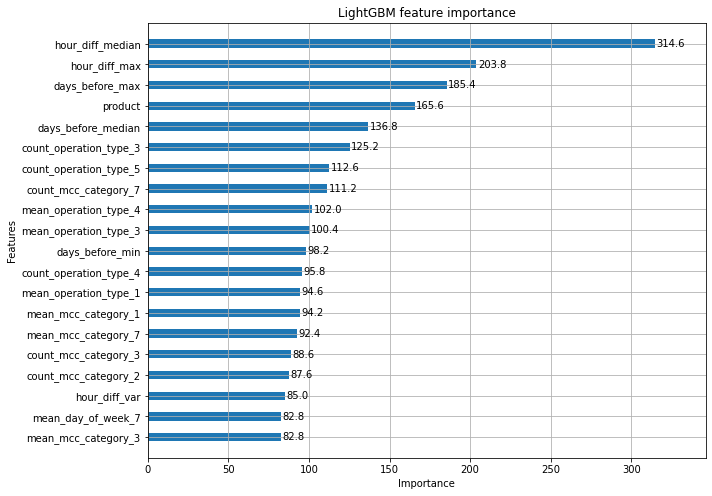

In [16]:
plot_feature_importance(features, importances, top_feats=20, title='LightGBM feature importance', 
                        x_label='Importance')

In [17]:
tuples = [(name, round(score, 3)) for name, score in zip(features, importances)]
tuples = sorted(tuples, key=lambda x: x[1])

top_selected_feats = [x[0] for x in tuples if x[1] >= np.median(importances)]
print(f'Кол-во отобранных признаков на этапе Feature importance (median):= {len(top_selected_feats)}')

Кол-во отобранных признаков на этапе Feature importance (median):= 64


# 6. LightGBM + CV (2)
---
## 6.1. Вторая модель (model2)
(на признаках расчетная важность которых не меньше медианы)

In [18]:
num_model = 2

In [19]:
!mkdir model2

In [20]:
%%time

oof = np.zeros(len(merged_train_data))
train_preds = np.zeros(len(merged_train_data))

new_models = []

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 3,
    'reg_lambda': 1,
    'num_leaves': 64,
    'n_jobs': 5,
    'n_estimators': 1000
}


for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_train_data, targets), 1):
    print(f'Началось обучение на фолде номер:= {fold_}.')
    lgb_model = lgb.LGBMClassifier(**tree_params)
    train, val = merged_train_data.iloc[train_idx], merged_train_data.iloc[val_idx]
    
    lgb_model.fit(train[top_selected_feats], train.flag.values, eval_set=[(val[top_selected_feats], val.flag.values)],
              early_stopping_rounds=50, verbose=50)

    oof[val_idx] = lgb_model.predict_proba(val[top_selected_feats])[:, 1]
    train_preds[train_idx] += lgb_model.predict_proba(train[top_selected_feats])[:, 1] / (cv.n_splits-1)
    new_models.append(lgb_model)
    
    file_name_model = f'model{num_model}/model{num_model}_{fold_}.txt'
    lgb_model.booster_.save_model(PATH_TO_WORKDIR+file_name_model)
    print(f'Обучение на фолде номер:= {fold_} завершилось.')

Началось обучение на фолде номер:= 1.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.732074
[100]	valid_0's auc: 0.743551
[150]	valid_0's auc: 0.749233
[200]	valid_0's auc: 0.752616
[250]	valid_0's auc: 0.754898
[300]	valid_0's auc: 0.756749
[350]	valid_0's auc: 0.758199
[400]	valid_0's auc: 0.758997
[450]	valid_0's auc: 0.759861
[500]	valid_0's auc: 0.760592
[550]	valid_0's auc: 0.761319
[600]	valid_0's auc: 0.761826
[650]	valid_0's auc: 0.762646
[700]	valid_0's auc: 0.76319
[750]	valid_0's auc: 0.763767
[800]	valid_0's auc: 0.764103
[850]	valid_0's auc: 0.764452
[900]	valid_0's auc: 0.764745
[950]	valid_0's auc: 0.764983
[1000]	valid_0's auc: 0.765198
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.765198
Обучение на фолде номер:= 1 завершилось.
Началось обучение на фолде номер:= 2.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.734279
[100]	valid_0's auc: 0.747565
[150]	valid_0's auc: 0.7

In [21]:
file_name_pickle = PATH_TO_WORKDIR + f'model{num_model}/feats_model{num_model}.pickle'
with open(file_name_pickle, 'wb') as f:
    pickle.dump(top_selected_feats, f)

In [22]:
f'Train roc-auc model{num_model}', roc_auc_score(targets, train_preds)

('Train roc-auc model2', 0.7966375744839358)

In [23]:
f'CV roc-auc model{num_model}', roc_auc_score(targets, oof)

('CV roc-auc model2', 0.7684856517031308)

In [24]:
score = np.zeros(len(merged_test_data))

for model in tqdm.tqdm_notebook(new_models):
    score += model.predict_proba(merged_test_data[top_selected_feats])[:, 1] / len(models)
    
submission = pd.DataFrame({
    'app_id' : merged_test_data.app_id.values,
    'score': score
}) 

submission.to_csv(f'sub_model{num_model}.csv', index=None)  # ~ 0.7346 на public test

  0%|          | 0/5 [00:00<?, ?it/s]

# 7. Permutation importance
---
Это способ оценки важности признаков, который можно применить к любой обученной модели на табличных данных. Данный тип важности определеяется для каждого признака, как изменение в скоре (в нашем случае - roc_auc) при случайном перемешиваниии столбца с значениями этого признака несколько раз.

In [25]:
%%time
permut_importance = np.zeros(len(features))

for fold_, (_, val_idx) in enumerate(cv.split(merged_train_data, targets), 1):
    print(f'Началась обработка фолда:= {fold_}')
    val = merged_train_data.iloc[val_idx]
    importances_report = permutation_importance(models[fold_-1], val[features], val.flag.values, n_repeats=3, 
                                     n_jobs=3, scoring='roc_auc')
    permut_importance += importances_report.importances_mean / cv.n_splits
    print(f'Обработка фолда:= {fold_} закончена.')

Началась обработка фолда:= 1
Обработка фолда:= 1 закончена.
Началась обработка фолда:= 2
Обработка фолда:= 2 закончена.
Началась обработка фолда:= 3
Обработка фолда:= 3 закончена.
Началась обработка фолда:= 4
Обработка фолда:= 4 закончена.
Началась обработка фолда:= 5
Обработка фолда:= 5 закончена.
CPU times: user 2min 31s, sys: 3.14 s, total: 2min 34s
Wall time: 2h 22min 5s


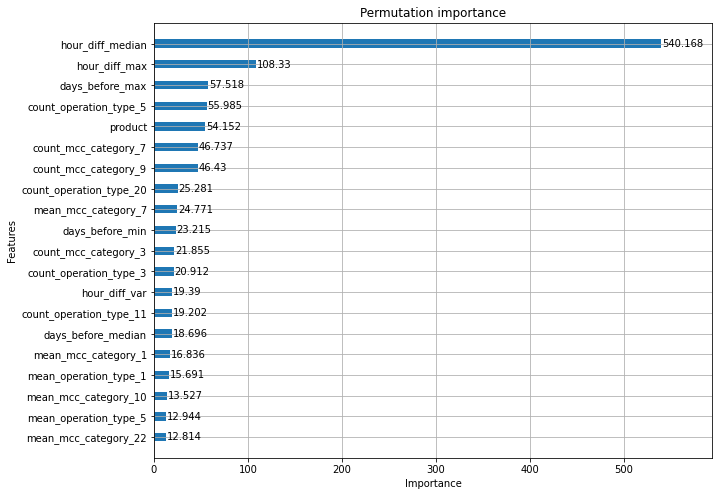

In [26]:
plot_feature_importance(features, permut_importance*10000, top_feats=20, title='Permutation importance', 
                        x_label='Importance')

Используя техники оценки важности признаков можно интерпретировать модель, пытаться генерировать новые признаки или упрощать модель, удаляя самые неинформативные. Попробуем оставить топ информативных признаков (с точки зрения) `permutation importance`. Удаление из модели признаков, как правило, уменьшает ее склонность к переобучению. А самое главное - может существенно ускорить процесс обучения и последующий процесс использования ее в продуктовых целях, что для меня достаточно важно потому что есть цель развернуть деплой модели на heroku, а его мощности скромные. 

In [27]:
tuples = [(name, round(score, 3)) for name, score in zip(features, permut_importance)]
tuples = sorted(tuples, key=lambda x: x[1])

top_selected_feats = [x[0] for x in tuples if x[1] > 0]
print(f'Кол-во отобранных признаков после метода Permutation importance:= {len(top_selected_feats)}')

Кол-во отобранных признаков после метода Permutation importance:= 59


# 8. LightGBM + CV (3)
---
## 8.1. Третья модель (model3)
(на признаках после отбора с помощью методов Features importance(median) и Permutation importance)

In [28]:
num_model = 3

In [29]:
!mkdir model3

In [30]:
%%time

oof = np.zeros(len(merged_train_data))
train_preds = np.zeros(len(merged_train_data))

new_models = []

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 3,
    'reg_lambda': 1,
    'num_leaves': 64,
    'n_jobs': 5,
    'n_estimators': 1000
}


for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_train_data, targets), 1):
    print(f'Training with fold {fold_} started.')
    lgb_model = lgb.LGBMClassifier(**tree_params)
    train, val = merged_train_data.iloc[train_idx], merged_train_data.iloc[val_idx]
    
    lgb_model.fit(train[top_selected_feats], train.flag.values, eval_set=[(val[top_selected_feats], val.flag.values)],
              early_stopping_rounds=50, verbose=50)

    
    oof[val_idx] = lgb_model.predict_proba(val[top_selected_feats])[:, 1]
    train_preds[train_idx] += lgb_model.predict_proba(train[top_selected_feats])[:, 1] / (cv.n_splits-1)
    new_models.append(lgb_model)
    
    file_name_model = f'model{num_model}/model{num_model}_{fold_}.txt'
    lgb_model.booster_.save_model(PATH_TO_WORKDIR+file_name_model)
    print(f'Training with fold {fold_} completed.')

Training with fold 1 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.732309
[100]	valid_0's auc: 0.744569
[150]	valid_0's auc: 0.750253
[200]	valid_0's auc: 0.754019
[250]	valid_0's auc: 0.756444
[300]	valid_0's auc: 0.75841
[350]	valid_0's auc: 0.759746
[400]	valid_0's auc: 0.761028
[450]	valid_0's auc: 0.761938
[500]	valid_0's auc: 0.762736
[550]	valid_0's auc: 0.763511
[600]	valid_0's auc: 0.764089
[650]	valid_0's auc: 0.764543
[700]	valid_0's auc: 0.764937
[750]	valid_0's auc: 0.765457
[800]	valid_0's auc: 0.765846
[850]	valid_0's auc: 0.766139
[900]	valid_0's auc: 0.766406
[950]	valid_0's auc: 0.766699
[1000]	valid_0's auc: 0.766831
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.766842
Training with fold 1 completed.
Training with fold 2 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.735958
[100]	valid_0's auc: 0.748533
[150]	valid_0's auc: 0.754005
[200]	valid_0's auc:

In [31]:
file_name_pickle = PATH_TO_WORKDIR + f'model{num_model}/feats_model{num_model}.pickle'
with open(file_name_pickle, 'wb') as f:
    pickle.dump(top_selected_feats, f)

In [32]:
f'Train roc-auc model{num_model}', roc_auc_score(targets, train_preds)

('Train roc-auc model3', 0.7965938860875296)

In [33]:
f'CV roc-auc model{num_model}', roc_auc_score(targets, oof)

('CV roc-auc model3', 0.7696292621024237)

In [34]:
score = np.zeros(len(merged_test_data))

for model in tqdm.tqdm_notebook(new_models):
    score += model.predict_proba(merged_test_data[top_selected_feats])[:, 1] / len(models)
    
submission = pd.DataFrame({
    'app_id' : merged_test_data.app_id.values,
    'score': score
}) 

submission.to_csv(f'sub_model{num_model}.csv', index=None)  # ~ 0.736 roc-auc на public test

  0%|          | 0/5 [00:00<?, ?it/s]

# 9. Интерпретация предсказаний модели (shap)
---
В задаче кредитного скорринга важна интепретируемость модели, для этого можно использовать  библиотеку shap. Мы используем так называемый summary plot, позволяющий получить общую картину о влиянии того или иного признака на предсказание модели визуализуруя всю выборку сразу. Я не смог разобраться как использовать методы shap для модели обученной на 5-ти фолдах. Ниже я заново обучаю модель после сплита 90:10 без деления на фолды, чтобы выделить основные закономерности влияния фич на таргет и попытаться визуализировать их разделяющую способность.

In [35]:
%%time
train, val = train_test_split(merged_train_data, random_state=100, test_size=0.1)

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 3,
    'reg_lambda': 1,
    'num_leaves': 64,
    'seed': 100,
    'n_jobs': 5,
    'n_estimators': 1000
}

lgb_model = lgb.LGBMClassifier(**tree_params)
lgb_model.fit(train[features], train.flag.values, eval_set=[(val[features], val.flag.values)],
              early_stopping_rounds=50, verbose=-1)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.765385
CPU times: user 6min 18s, sys: 5.2 s, total: 6min 24s
Wall time: 2min 12s


LGBMClassifier(learning_rate=0.05, max_depth=3, metric='auc', n_estimators=1000,
               n_jobs=5, num_leaves=64, objective='binary', reg_lambda=1,
               seed=100)

In [36]:
explainer = shap.TreeExplainer(lgb_model)

In [37]:
shap_values = explainer.shap_values(val[features])

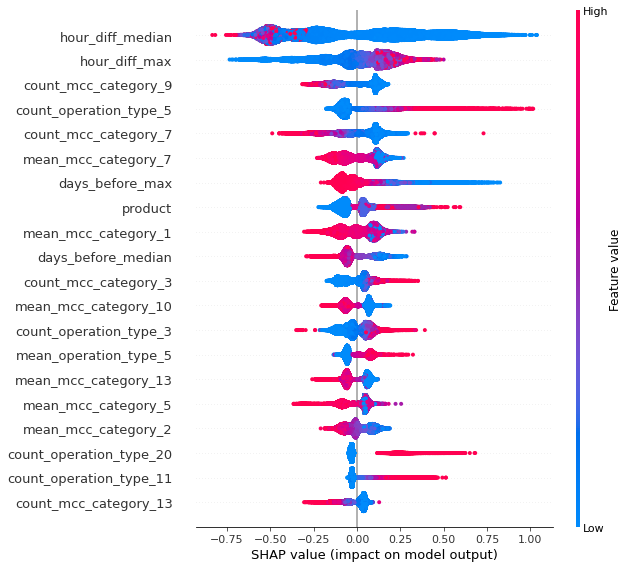

In [38]:
shap.summary_plot(shap_values[1], val[features])

График выше показывает влияние и разделяющую способность признаков:
- каждая точка графика это клиент
- цвет - значение прогноза дефолта, чем краснее - тем прогноз дефолта выше, и наоборот
- горизонтальное положение точки показывает, приводит ли значение конкретной фичи этого клиента к росту предсказания дефолта, или наоборот.

***Например можно увидеть следующие тренды:***

1. уменьшение признака 'hour_diff_median' приводит к росту значения целевой переменной (то есть можно предположить, что клиенту приходится делать транзакции слишком часто - а это свидетельство того, что клиент вероятнее выйдет в дефолт, чем клиент который чувствует себя более уверенно в финансовом плане и может позволить делать крупные оплаты сразу не разбивая их на части)
2. увеличение признака 'hour_diff_max' приводит к росту значения целевой переменной (то есть можно предположить, что клиент долго не пользовался картой это могло произойти в следствии овердрафта и необходимости перекредитования в другом банке)
3. уменьшение признака 'count_mcc_category_9' приводит к росту значения целевой переменной (к сожалению категории торговых точек как данные о клиентах были обезличены, остается только предположить, что вероятно это категория 'Кафе,бары и рестораны' и клиенты испытывающие сложности в финансах перестают их посещать или делают это существенно реже.)
4. увеличение признака 'count_operation_type_5' приводит к росту значения целевой переменной (из-за обезличивания типа операций и дополнительного анализа видно что у большинства клиентов таких операций нет, вероятно речь об операции внесение минимального платежа, вместо гашения очередного платежа. И собственно если это так что увеличение кол-ва таких операций приводит к дефолту потому что нагрузка в этом случае только возрастает)
5. среднее и максимальное значение признака 'product' приводит к росту значения целевой переменной (предположу что 0 - кредит безналичными на карту, 1 - это кредит наличными, 2 - кредит на крупные покупки, 3 - кредит на покупку авто, 4 - ипотека. Сделать такое предположение можно и-за того что 80% всех кредитов по кол-ву приходится на продукты 0,1. А самый редкий это продукт 4. Среднее значение дефолтов 2-2,5% процента по продуктам 0,1,3. По продукту 2 - 7%. А по продукту 4 - 3%. Вероятно кредиты на крупные покупки проверяются менее чем ипотека и они не имеют обеспечения как авто для погашения кредита.)
6. уменьшение признака 'days_before_max' приводит к росту значения целевой переменной (низкое значение максимума кол-ва дней перед взятием кредита означает короткая история транзакций в банке. Можно предположить, что клиент открыл карту и через короткое время получил кредит. Это либо мошеническая схема, но этот вариант мы не рассматривает ибо он скорее всего не массовый. А вероятно это случай перекредитования в другом банке, когда банк по соновной карте перестал предоставлять или увеличивать кредитную линию. Что является свидетельством неплатежеспособности клиента.)

# 10. Target Permutation
---
Отбор признаков методом target permutation основан на сравнении важности признака, которая быал получена при обучении на обычной выборке, с распределением важности этого признака для моделей, которые обучены на выборках с перемешанной целевой переменной.

In [39]:
def get_feature_importances(frame, shuffle=False, seed=100, importance_type='gain'):
    # запишем целевую target в переменную
    y = frame.flag.values.copy()
    if shuffle:
        # перемешаем целевую переменную
        y = frame.flag.copy().sample(frac=1.0).values
    
    # обучим случайный лес из LightGBM ( реализация гораздо быстрее, чем в sklearn )
    # сделаем это для того, чтобы не выделять отдельную выборку под валидацию для градиентного бустинга
    tree_params = {
    'objective': 'binary',
    'boosting_type': 'rf',
    'metric': 'auc',
    'subsample_freq': np.random.choice([5, 10, 15, 20]),
    'subsample': np.random.choice([0.6, 0.8, 0.9]),
    'max_depth': np.random.choice([7, 8, 10]),
    'num_leaves': 64,
    'seed': seed,
    'n_jobs': 5,
    'n_estimators': 100,
    'importance_type': importance_type
    }
    
    lgb_model = lgb.LGBMClassifier(**tree_params)
    lgb_model.fit(frame[features], y)
    
    importance = pd.DataFrame({
        'feature': features,
        f'importance_{importance_type}': lgb_model.feature_importances_,
        'score': roc_auc_score(y, lgb_model.predict_proba(frame[features])[:, 1])
    })
    
    return importance

Посчитаем важность признаков (на основе количества сплитов по признаку в алгоритме random forest) при обучении на исходной выборке

In [40]:
real_importance = get_feature_importances(train, shuffle=False, seed=100, importance_type='split')
real_importance.head()

,feature,importance_split,score
0,count_mcc_category_1,15,0.71922
1,count_mcc_category_2,45,0.71922
2,count_mcc_category_3,15,0.71922
3,count_mcc_category_4,75,0.71922
4,count_mcc_category_5,15,0.71922


Посчитаем важность признаков для выборок, у которых целевая переменная перемешана. То есть фактически, обучаем алгоритм на шуме.

In [41]:
def calculate_null_importance(frame, num_runs=80, importance_type='gain'):
    null_importance = pd.DataFrame()
    for i in tqdm.tqdm_notebook(range(num_runs)):
        # посчитаем текущую важность признаков при перемешивании целевой переменной
        importance = get_feature_importances(frame, shuffle=True, seed=None, importance_type=importance_type)
        importance['run'] = i + 1 
        null_importance = pd.concat([null_importance, importance], axis=0)
    return null_importance

In [42]:
%%time
null_importance = calculate_null_importance(train, num_runs=30, importance_type='split')

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 40min 44s, sys: 1min 19s, total: 42min 4s
Wall time: 15min 18s


Теперь имеем возможность для каждого признака построить гистограмму важности этого признака при обучении на выборке с перемешанным таргетом и на выборке с реальной целевой переменной. В идеале, гистограмма должна быть как можно дальше от реального значения важности признака

In [43]:
def plot_distribution(real_importance, null_importance, feature_name, importance_name='gain'):
    fig, ax = plt.subplots(figsize=(8, 6))
    a = ax.hist(null_importance.loc[null_importance['feature'] == feature_name, f'importance_{importance_name}'].values, 
                label='Null importances')
    
    ax.vlines(x=real_importance.loc[real_importance['feature'] == feature_name, f'importance_{importance_name}'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title(f'Split Importance of {feature_name}', fontweight='bold')
    plt.xlabel(f'Null Importance ({importance_name}) Distribution for {feature_name}')

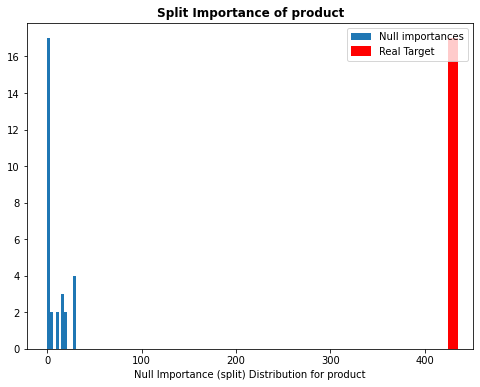

In [44]:
plot_distribution(real_importance, null_importance, feature_name='product', importance_name='split')

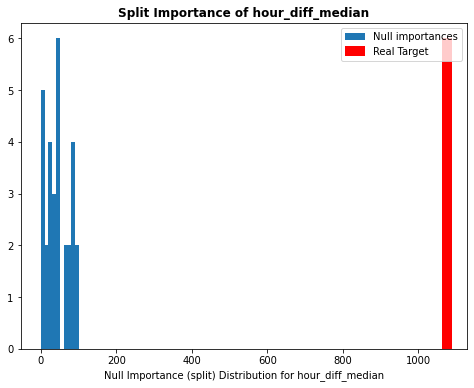

In [45]:
plot_distribution(real_importance, null_importance, feature_name='hour_diff_median', importance_name='split')

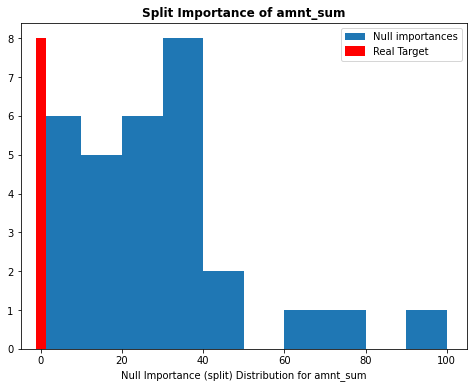

In [46]:
plot_distribution(real_importance, null_importance, feature_name='amnt_sum', importance_name='split')

Попробуем поставить каждому признаку новый скор, важность, с учетом той информации, которую имеем. Один из вариантов - поделить реальноа значение важности признака на среднее значение для перемешанных важностей этого признака. 

In [47]:
scores = []
importance_name = 'split'

for feature in features:
    hist_null_importance = null_importance.loc[null_importance['feature'] == feature, f'importance_{importance_name}'].values
    actual_importance = real_importance.loc[real_importance['feature'] == feature, f'importance_{importance_name}'].mean()
    score = (1e-10 + actual_importance) / (1 + np.mean(hist_null_importance))        
    scores.append(round(score, 3))

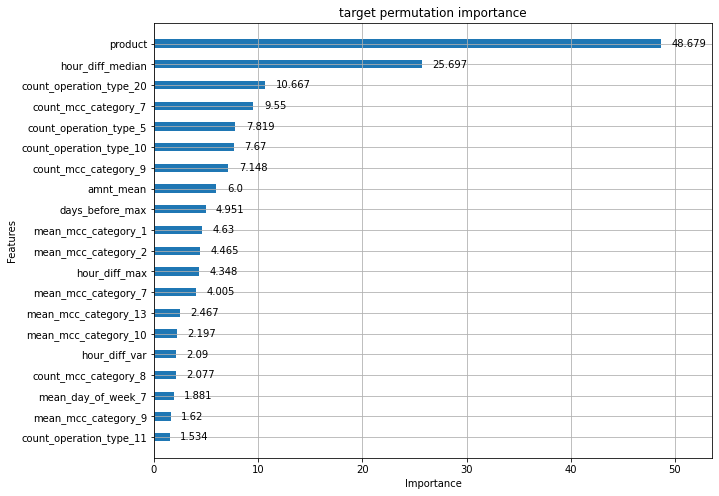

In [48]:
plot_feature_importance(features, scores, top_feats=20, title='target permutation importance', 
                        x_label='Importance')

In [49]:
tuples = [(name, round(score, 3)) for name, score in zip(features, scores)]
tuples = sorted(tuples, key=lambda x: x[1])

top_selected_feats = [x[0] for x in tuples if x[1] > 0]
print(f'Кол-во отобранных признаков после всех методов отбора:= {len(top_selected_feats)}')

Кол-во отобранных признаков после всех методов отбора:= 52


# 11. LightGBM + CV (4)
---
## 11.1. Четвертая модель (model4)
(на признаках после отбора с помощью всех методов Features importance(median), Permutation importance и Target importance)

In [50]:
num_model = 4

In [51]:
!mkdir model4

In [52]:
%%time

oof = np.zeros(len(merged_train_data))
train_preds = np.zeros(len(merged_train_data))

new_models = []

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 3,
    'reg_lambda': 1,
    'num_leaves': 64,
    'n_jobs': 5,
    'n_estimators': 1000
}


for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_train_data, targets), 1):
    print(f'Training with fold {fold_} started.')
    lgb_model = lgb.LGBMClassifier(**tree_params)
    train, val = merged_train_data.iloc[train_idx], merged_train_data.iloc[val_idx]
    
    lgb_model.fit(train[top_selected_feats], train.flag.values, eval_set=[(val[top_selected_feats], val.flag.values)],
              early_stopping_rounds=50, verbose=50)

    
    oof[val_idx] = lgb_model.predict_proba(val[top_selected_feats])[:, 1]
    train_preds[train_idx] += lgb_model.predict_proba(train[top_selected_feats])[:, 1] / (cv.n_splits-1)
    new_models.append(lgb_model)
    
    file_name_model = f'model{num_model}/model{num_model}_{fold_}.txt'
    lgb_model.booster_.save_model(PATH_TO_WORKDIR+file_name_model)
    print(f'Training with fold {fold_} completed.')

Training with fold 1 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.732007
[100]	valid_0's auc: 0.743403
[150]	valid_0's auc: 0.748255
[200]	valid_0's auc: 0.751106
[250]	valid_0's auc: 0.753179
[300]	valid_0's auc: 0.754779
[350]	valid_0's auc: 0.755701
[400]	valid_0's auc: 0.756664
[450]	valid_0's auc: 0.757523
[500]	valid_0's auc: 0.758219
[550]	valid_0's auc: 0.75876
[600]	valid_0's auc: 0.759017
[650]	valid_0's auc: 0.759537
[700]	valid_0's auc: 0.759872
[750]	valid_0's auc: 0.760291
[800]	valid_0's auc: 0.760651
[850]	valid_0's auc: 0.760947
[900]	valid_0's auc: 0.761206
[950]	valid_0's auc: 0.76141
[1000]	valid_0's auc: 0.761639
Did not meet early stopping. Best iteration is:
[996]	valid_0's auc: 0.761659
Training with fold 1 completed.
Training with fold 2 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.733988
[100]	valid_0's auc: 0.747403
[150]	valid_0's auc: 0.752494
[200]	valid_0's auc: 

In [53]:
file_name_pickle = PATH_TO_WORKDIR + f'model{num_model}/feats_model{num_model}.pickle'
with open(file_name_pickle, 'wb') as f:
    pickle.dump(top_selected_feats, f)

In [54]:
f'Train roc-auc model{num_model}', roc_auc_score(targets, train_preds)

('Train roc-auc model4', 0.7918817570812984)

In [55]:
f'CV roc-auc model{num_model}', roc_auc_score(targets, oof)

('CV roc-auc model4', 0.7650961673259608)

In [56]:
score = np.zeros(len(merged_test_data))

for model in tqdm.tqdm_notebook(new_models):
    score += model.predict_proba(merged_test_data[top_selected_feats])[:, 1] / len(models)
    
submission = pd.DataFrame({
    'app_id' : merged_test_data.app_id.values,
    'score': score
})
submission.to_csv(f'sub_model{num_model}.csv', index=None)  # ~ 0.733 на public test

  0%|          | 0/5 [00:00<?, ?it/s]

Расчет модели Catboost реализован в следующем кернеле, чтобы не использовать квоту так как запускается на GPU

**Результаты всех экспериментов моделей (метрика AUC ROC):**  
                    Model                            | число призн. |    Train     |     CV      |   Public Test      
---  
                     lgb+cv(5)                     |        127           |    0.801    |    0.77     |    0.737       
       lgb+cv(5)+split_importance      |          64            |    0.795    |    0.767    |    0.735  
lgb+cv(5)+permutation_importance |         57            |    0.796    |    0.768    |    0.736   
    lgb+cv(5)+target_permutation     |          60            |    0.796    |    0.766    |    0.733 
